<a href="https://colab.research.google.com/github/ZheldakS/GB_homework/blob/main/ZheldakSL_DS_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Курсовой проект для курса "Python для Data Science"

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Описания полей датасета по недвижимости

Id - идентификационный номер квартиры,

DistrictId - идентификационный номер района,

Rooms - количество комнат,

Square - площадь,

LifeSquare - жилая площадь,

KitchenSquare - площадь кухни,

Floor - этаж,

HouseFloor - количество этажей в доме,

HouseYear - год постройки дома,

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности,

Social_1, Social_2, Social_3 - социальные показатели местности,

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья,

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров,

Price - цена квартиры.

In [48]:

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [49]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
TEST_DATASET_EXT_PATH = 'ZheldakSL_predictions.csv'


In [50]:
# Функция для отображения scatter-графика по двум признакам.
def draw_scatter(column_x, column_y, df):
    plt.scatter(df[column_x], df[column_y])
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.show()  

In [51]:
# Функция вырезает из выборки выбросы. (обработку выбросов честно спер :))
def drop_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n'.format(column, IQ, low_border, high_border))
    
    size_before = df[column].size
    df.drop(df[(df[column]<low_border)|(df[column]>high_border)].index, axis=0, inplace=True)    
    size_after = df[column].size
    
    lost_percentage = (size_before - size_after) * 100 / size_before 
    print('Lost {}% of data.'.format('%0.2f' % lost_percentage))


In [52]:
# Функция заменяет выбросы в выборке на среднее значение по признаку. (обработку выбросов честно спер :))
def replace_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    mean = df[column].mean()
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n\tMEAN:\t{}'.format(column, IQ, low_border, high_border, mean))

    index_to_replace = df[(df[column]<low_border)|(df[column]>high_border)].index

    df.loc[index_to_replace, column] = mean
    print('In {} row {} was replaced to {}.'.format(index_to_replace.size, column, mean))


In [88]:
# Функция считает метрику r2_score и mae по переданным наборам данных и модели.
def fit_pred(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    
    y_train_pred = model.predict(x_train) 
    y_test_pred = model.predict(x_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mae(y_train, y_train_pred)
    print(f'r2_train = {r2_train}, mae_train: {mae_train}')
    
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mae(y_test, y_test_pred)
    print(f'r2_test = {r2_test}, mae_test: {mae_test}')


In [53]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040         B         B        33      7976   
1         9.0       1978   0.000070         B         B        46     10309   
2        12.0       1968   0.049637         B         B        34      7759   
3        17.0       1977   0.437885         B         B        23      5735   
4        12.0       1976   0.012339         B         B        35      5776   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         5           NaN            0       11       B  184966.930730  
1         1         240.0            1       16       B  300009.450063  
2         0         229.0            1        3       B  220925.908524  
3         3        1084.0            0        5       B  175616.227217  
4         1        2078.0            2        4       B  150226.531644

In [54]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Датасет содержит три категориальных признака (Ecology_2, Ecology_3, Shops_2). По двум признакам есть пропущенные значения (LifeSquare, Healthcare_1).

In [56]:
df.describe()

Id    DistrictId         Rooms        Square   LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  7887.000000   
mean    8383.40770     50.400800      1.890500     56.315775    37.199645   
std     4859.01902     43.587592      0.839512     21.058732    86.241209   
min        0.00000      0.000000      0.000000      1.136859     0.370619   
25%     4169.50000     20.000000      1.000000     41.774881    22.769832   
50%     8394.50000     36.000000      2.000000     52.513310    32.781260   
75%    12592.50000     75.000000      2.000000     65.900625    45.128803   
max    16798.00000    209.000000     19.000000    641.065193  7480.592129   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
std        28.560917      5.241148      6.775974  2.005003e+05      0.119025   
min         0.000000      1.000000      0.000000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1   Helthcare_2  \
count  10000.000000  10000.000000  10000.000000   5202.000000  10000.000000   
mean      24.687000   5352.157400      8.039200   1142.904460      1.319500   
std       17.532614   4006.799803     23.831875   1021.517264      1.493601   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7227.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  10000.000000   10000.000000  
mean       4.231300  214138.857399  
std        4.806341   92872.293865  
min        0.000000   59174.778028  
25%        1.000000  153872.633942  
50%        3.000000  192269.644879  
75%        6.000000  249135.462171  
max       23.000000  633233.466570

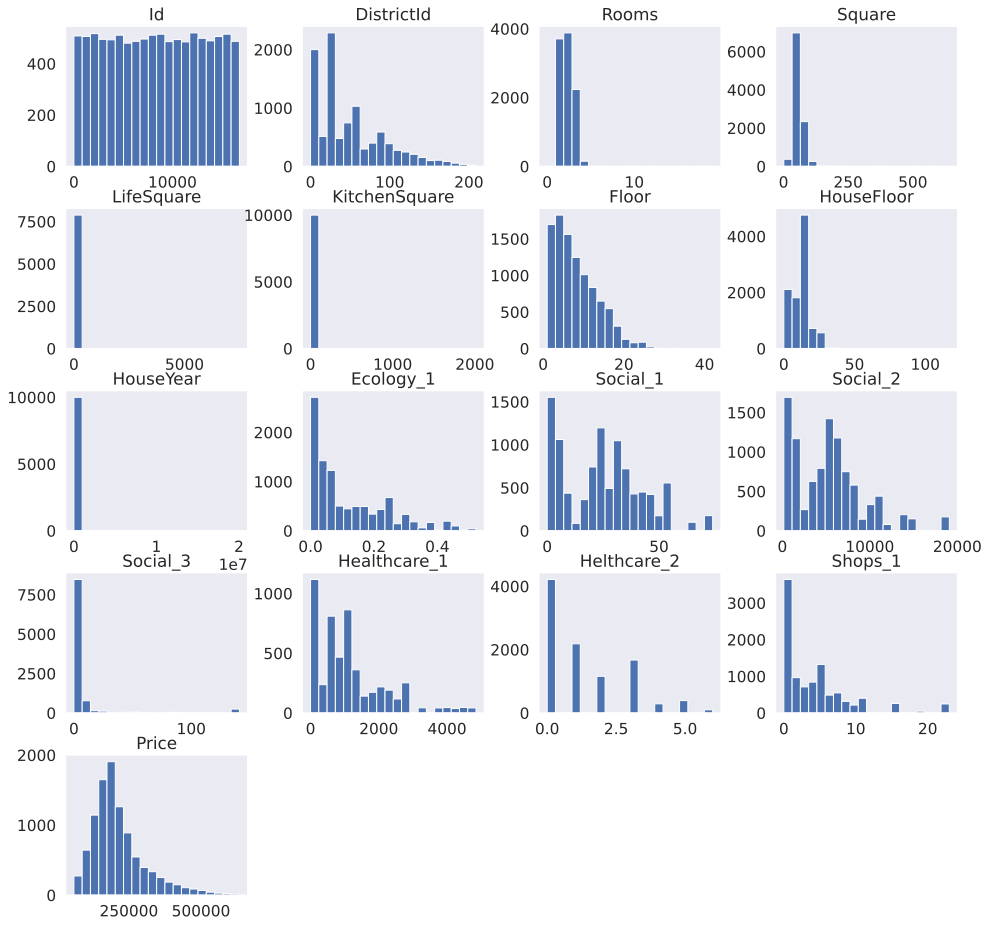

In [57]:
df.hist(figsize=(16,16), bins=20, grid=False);

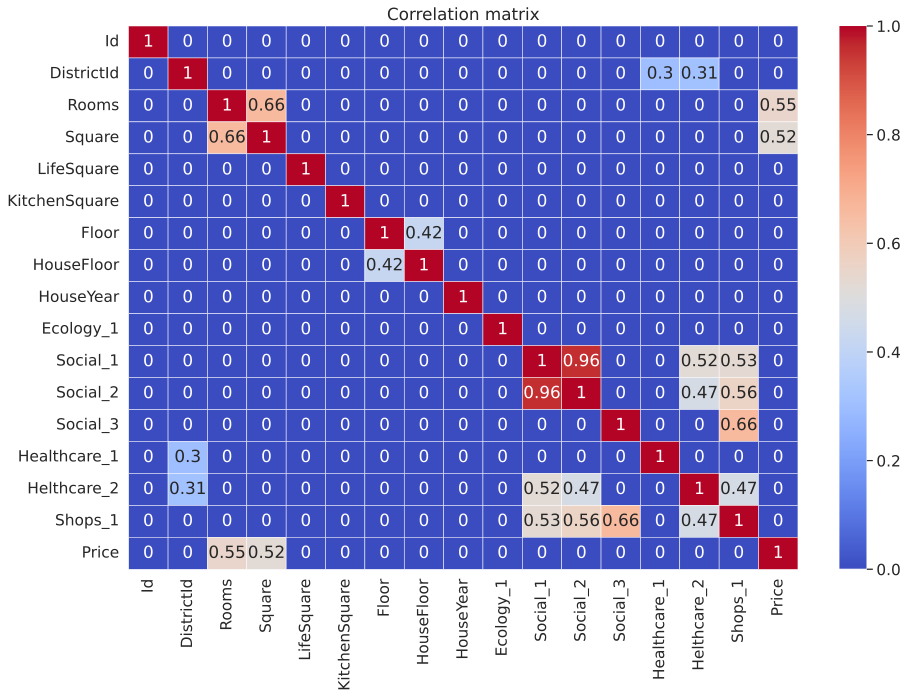

In [58]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [59]:
obj_features = df.select_dtypes(include='object').columns
obj_features

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

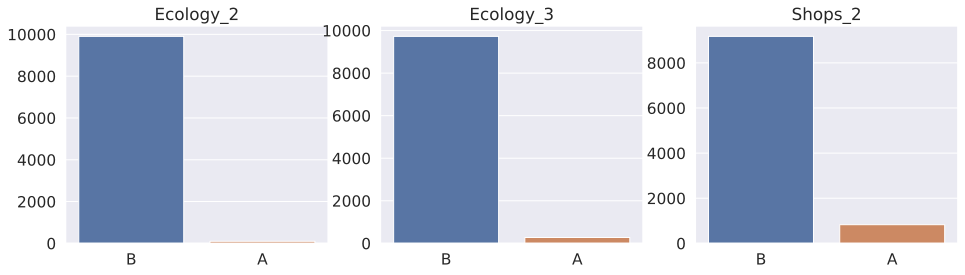

In [60]:
plt.figure(figsize = (16,4))

for i, colname in enumerate(obj_features):
    counts = df[colname].value_counts()
    
    plt.subplot(1,3,i+1)    
    plt.title(colname)
    sns.barplot(counts.index, counts.values)
    
plt.show()

In [61]:
for column in obj_features:
    print('{}\n'.format(df[column].value_counts()))


B    9903
A      97
Name: Ecology_2, dtype: int64

B    9725
A     275
Name: Ecology_3, dtype: int64

B    9175
A     825
Name: Shops_2, dtype: int64



Так как признаки принимают всего два значения, заменим их на бинарные признаки.

In [62]:
for column in obj_features:
        unique_true = df[column].unique()[1]
        df[column]  = df[column] == unique_true

In [63]:
for column in obj_features:
    print('{}\n'.format(df[column].value_counts()))

False    9903
True       97
Name: Ecology_2, dtype: int64

False    9725
True      275
Name: Ecology_3, dtype: int64

False    9175
True      825
Name: Shops_2, dtype: int64



Количество значений не изменилось, значит преобразование сделано правильно.

Признак Healthcare_1 содержит очень много пропущенных значений. Не будем учитывать этот признак в процессе анализа.

In [64]:
 df.drop(['Healthcare_1'], axis=1, inplace=True)

Исследуем значения признаков LifeSquare и Square. Попробуем установить зависимость между жилой площадью и полной площадью квартиры.

In [65]:
df['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [66]:
df['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

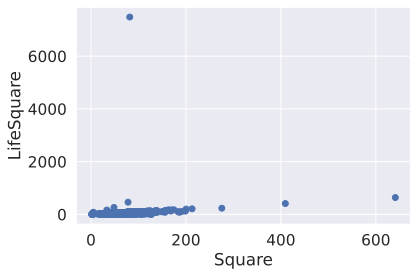

In [67]:
draw_scatter('Square', 'LifeSquare', df)

Оба признака имеют выбросы. Избавимся от них.

In [68]:
drop_by_IQ('Square', df)

For column Square
	IQ:	24.125744426186976
	LOW:	5.586264180189367
	HIGH:	102.08924188493728

Lost 2.42% of data.


In [69]:
drop_by_IQ('LifeSquare', df)

For column LifeSquare
	IQ:	21.756925644753355
	LOW:	-9.940131635100524
	HIGH:	77.08757094391291

Lost 1.91% of data.


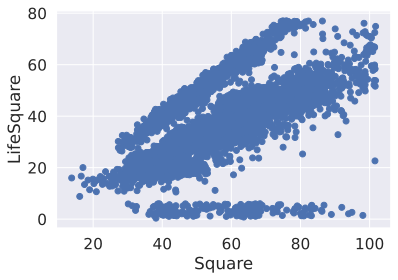

In [70]:
draw_scatter('Square', 'LifeSquare', df)

Найдём долю жилой площади от общей по сроедним значениям в выборке и заполним пропущенные значения в столбце LifeSquare.

In [71]:
square_mean_values = df[['Square', 'LifeSquare']].dropna().mean()
square_coeff = square_mean_values[1] / square_mean_values[0]
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] * square_coeff


In [72]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9572 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9572 non-null   int64  
 1   DistrictId     9572 non-null   int64  
 2   Rooms          9572 non-null   float64
 3   Square         9572 non-null   float64
 4   LifeSquare     9572 non-null   float64
 5   KitchenSquare  9572 non-null   float64
 6   Floor          9572 non-null   int64  
 7   HouseFloor     9572 non-null   float64
 8   HouseYear      9572 non-null   int64  
 9   Ecology_1      9572 non-null   float64
 10  Ecology_2      9572 non-null   bool   
 11  Ecology_3      9572 non-null   bool   
 12  Social_1       9572 non-null   int64  
 13  Social_2       9572 non-null   int64  
 14  Social_3       9572 non-null   int64  
 15  Helthcare_2    9572 non-null   int64  
 16  Shops_1        9572 non-null   int64  
 17  Shops_2        9572 non-null   bool   
 18  Price   

In [73]:
df.describe()

Id   DistrictId        Rooms       Square   LifeSquare  \
count   9572.000000  9572.000000  9572.000000  9572.000000  9572.000000   
mean    8382.207376    50.579816     1.845905    54.118859    34.519826   
std     4856.596405    43.768356     0.809624    15.594497    13.030713   
min        2.000000     0.000000     0.000000    13.784865     0.370619   
25%     4169.500000    19.000000     1.000000    41.537091    24.065821   
50%     8390.500000    36.000000     2.000000    51.217517    32.871722   
75%    12591.250000    77.000000     2.000000    64.293638    43.319537   
max    16798.000000   209.000000    19.000000   102.032801    77.052978   

       KitchenSquare        Floor   HouseFloor     HouseYear    Ecology_1  \
count    9572.000000  9572.000000  9572.000000  9.572000e+03  9572.000000   
mean        6.243105     8.471061    12.586293  4.079251e+03     0.119942   
std        29.065509     5.168552     6.628252  2.049338e+05     0.119592   
min         0.000000     1.000000     0.000000  1.910000e+03     0.000000   
25%         1.000000     4.000000     9.000000  1.973000e+03     0.017647   
50%         6.000000     7.000000    12.000000  1.977000e+03     0.075779   
75%         9.000000    12.000000    17.000000  1.999000e+03     0.195781   
max      2014.000000    42.000000   117.000000  2.005201e+07     0.521867   

          Social_1      Social_2     Social_3  Helthcare_2      Shops_1  \
count  9572.000000   9572.000000  9572.000000  9572.000000  9572.000000   
mean     24.914333   5390.685959     8.029461     1.327518     4.237986   
std      17.488685   3994.347092    23.702448     1.485634     4.792616   
min       0.000000    168.000000     0.000000     0.000000     0.000000   
25%       6.000000   1564.000000     0.000000     0.000000     1.000000   
50%      25.000000   5285.000000     2.000000     1.000000     3.000000   
75%      36.000000   7287.000000     5.000000     2.000000     6.000000   
max      74.000000  19083.000000   141.000000     6.000000    23.000000   

               Price  
count    9572.000000  
mean   209182.371820  
std     87271.970772  
min     59174.778028  
25%    151904.418474  
50%    189610.138453  
75%    244221.524382  
max    633233.466570

Признак KitchenSquare содержит выбросы. Избавимся от них.

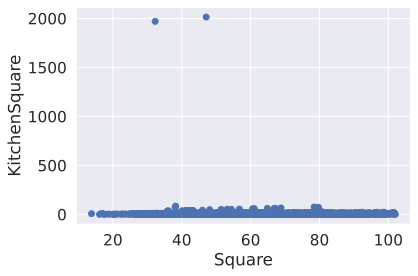

In [74]:

draw_scatter('Square', 'KitchenSquare', df)

In [75]:
replace_by_IQ('KitchenSquare', df)

For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	6.2431048892603425
In 31 row KitchenSquare was replaced to 6.2431048892603425.


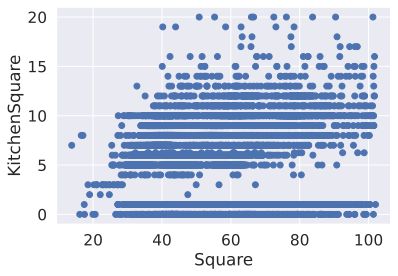

In [76]:
draw_scatter('Square', 'KitchenSquare', df)

Признак HouseYear так же содержит выпадающие значения. Обработаем их.

In [77]:
mean_year = np.round(df.loc[df['HouseYear'] <= 2020, 'HouseYear'].mean())
mean_year

1984.0

In [78]:
df.loc[df['HouseYear'] > 2020, 'HouseYear'] = mean_year

In [79]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])\
    .drop(['Id', 'DistrictId'], axis=1)

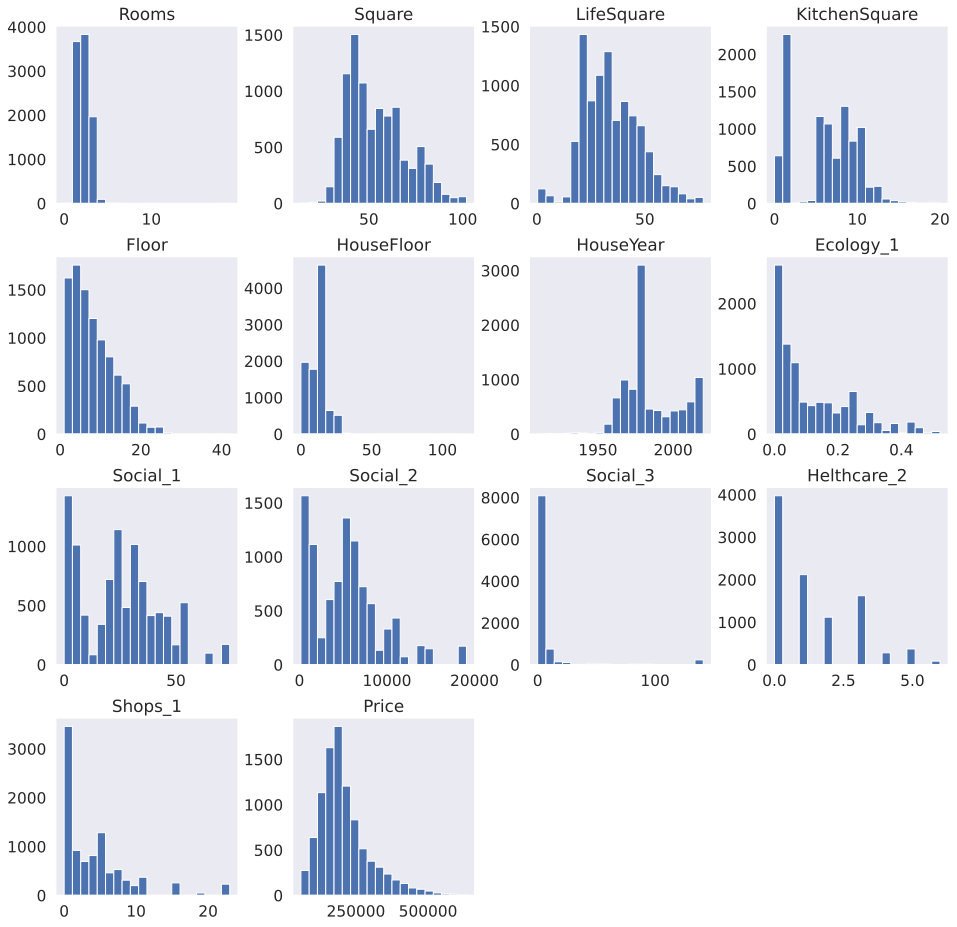

In [80]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

Выбросов нет. В процессе подготовки данных мы заменили категориальные признаки на бинарные. Исключили из анализа признак Healthcare_1. Исключили выбросы из выборки по признакам Square и LifeSquare. Заменили выбросы по признаку KitchenSquare на средние значения. И заполнили пропущенные значения по признаку LifeSquare. Сделаем то же самое для тестового датафрейма. Однако, вместо исключения выбросов по признакам Square и LifeSquare заменим выбросы на средние значения.

In [81]:
test = pd.read_csv(TEST_DATASET_PATH)

for column in obj_features:
        unique_true = test[column].unique()[1]
        test[column]  = test[column] == unique_true

test.drop(['Healthcare_1'], axis=1, inplace=True)
replace_by_IQ('Square', test)
replace_by_IQ('LifeSquare', test)

test.loc[test['LifeSquare'].isnull(), 'LifeSquare'] = test['Square'] * square_coeff

replace_by_IQ('KitchenSquare', test)

For column Square
	IQ:	24.37889829487171
	LOW:	5.337883253363636
	HIGH:	102.85347643285048
	MEAN:	56.449500363812504
In 110 row Square was replaced to 56.449500363812504.
For column LifeSquare
	IQ:	22.082065205778463
	LOW:	-10.031071759483922
	HIGH:	78.29718906362993
	MEAN:	36.158810455086694
In 118 row LifeSquare was replaced to 36.158810455086694.
For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	5.9768
In 19 row KitchenSquare was replaced to 5.9768.


Разобьем тестовый датасет на тестовый и валидационный.

In [82]:
features = df.columns.drop('Id').drop('DistrictId').drop('Price')
target = 'Price'


In [83]:
X = pd.DataFrame(df, columns=features)
y = pd.DataFrame(df, columns=[target])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [84]:

X_test = test[features]
X_test.head()


Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  HouseYear  \
0    2.0  49.882643   33.432782            6.0      6        14.0       1972   
1    2.0  69.263183   44.179664            1.0      6         1.0       1977   
2    1.0  13.597819   15.948246           12.0      2         5.0       1909   
3    2.0  73.046609   51.940842            9.0     22        22.0       2007   
4    1.0  47.527111   43.387569            1.0     17        17.0       2017   

   Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  Social_3  Helthcare_2  \
0   0.310199      False      False        11      2748         1            0   
1   0.075779      False      False         6      1437         3            0   
2   0.000000      False      False        30      7538        87            5   
3   0.101872      False      False        23      4583         3            3   
4   0.072158      False      False         2       629         1            0   

   Shops_1  Shops_2  
0        0    False  
1        2    False  
2        5    False  
3        3    False  
4        0     True

Масштабируем данные.

In [85]:
scaler = StandardScaler()

In [86]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

На тренировочном наборе модели LinearRegression, Lasso и Ridge дали примерно одинаковый результат r2+score = 0.5. Наилучший результат был получен на модели RandomForestRegressor с параметрами n_estimators=1000, max_depth=9, max_features=7, random_state=42.

In [89]:

model = RandomForestRegressor(n_estimators=1000, max_depth=9, max_features=7, random_state=42)
fit_pred(X_train_scaled, y_train, X_valid_scaled, y_valid, model)


r2_train = 0.8180479489416015, mae_train: 24423.64148174446
r2_test = 0.6798130124073907, mae_test: 30101.821074082596


Предсказываем цены для тестового датасета и выгружаем результат в файл. На сайте kaggle.com результат 0.688.

In [90]:

price = model.predict(X_test_scaled)
pd.DataFrame({ 'Id': test['Id'], 'Price': price }).to_csv(TEST_DATASET_EXT_PATH, index=False)